# FRUIT DRAWING CLASSIFICATION WEB-APP (BACKEND)

## Dependencies

In [1]:
!pip install q keras==2.2.4

     |████████████████████████████████| 317kB 21.3MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.6MB 48kB/s 
     |████████████████████████████████| 3.2MB 43.8MB/s 
     |████████████████████████████████| 368kB 50.1MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from pathlib import Path

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

## Mount to Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/My\ Drive/nn_prj/

data  food_model_89.08.pkl  food_model_cnn.pkl	templates


In [6]:
path = Path('/content/drive/My Drive/nn_prj/')
path

PosixPath('/content/drive/My Drive/nn_prj')

## Data Preprocessing

In [7]:
# load the dataset
# TOTAL = 5 Classes of fruits: Apple, Banana, Grapes, Pineapple, Strawberry
apple = np.load(path/'data/full_numpy_bitmap_apple.npy')
banana = np.load(path/'data/full_numpy_bitmap_banana.npy')
grapes = np.load(path/'data/full_numpy_bitmap_grapes.npy')
pineapple = np.load(path/'data/full_numpy_bitmap_pineapple.npy')
strawberry = np.load(path/'data/full_numpy_bitmap_strawberry.npy')

# Dataset Shape
print("Apple:", apple.shape)
print("Banana:", banana.shape)
print("Grapes:", grapes.shape)
print("Pineapple:", pineapple.shape)
print("Strawberry:", strawberry.shape)

Apple: (144722, 784)
Banana: (307936, 784)
Grapes: (155305, 784)
Pineapple: (125071, 784)
Strawberry: (122301, 784)


In [8]:
# For each class, we add a column to set the labels.
apple = np.c_[apple, np.zeros(len(apple))]
banana = np.c_[banana, np.ones(len(banana))]
grapes = np.c_[grapes, 2*np.ones(len(grapes))]
pineapple = np.c_[pineapple, 3*np.ones(len(pineapple))]
strawberry = np.c_[strawberry, 4*np.ones(len(strawberry))]

# Dataset Shape after adding column for labels
print("Apple:", apple.shape)
print("Banana:", banana.shape)
print("Grapes:", grapes.shape)
print("Pineapple:", pineapple.shape)
print("Strawberry:", strawberry.shape)

Apple: (144722, 785)
Banana: (307936, 785)
Grapes: (155305, 785)
Pineapple: (125071, 785)
Strawberry: (122301, 785)


Sample Drawings from the dataset

In [9]:
# Function to plot sample drawings
def plot_samples(input_array, rows=4, cols=5, title=''):
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)
    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

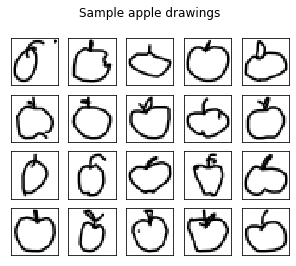

In [10]:
plot_samples(apple, title='Sample apple drawings\n')

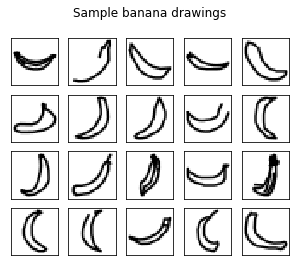

In [11]:
plot_samples(banana, title='Sample banana drawings\n')

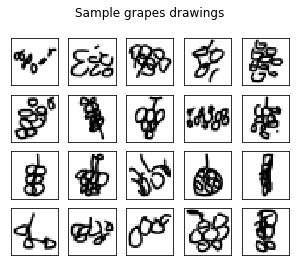

In [12]:
plot_samples(grapes, title='Sample grapes drawings\n')

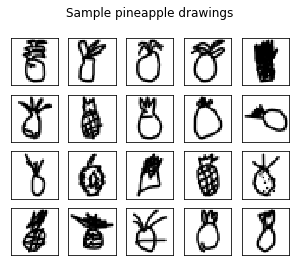

In [13]:
plot_samples(pineapple, title='Sample pineapple drawings\n')

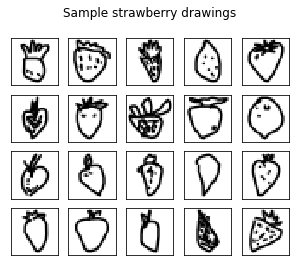

In [14]:
plot_samples(strawberry, title='Sample strawberry drawings\n')

## Data preparation for Model training

In [16]:
# Merging arrays and splitting the features and labels
# X = all columns but the last
X = np.concatenate((apple[:10000,:-1], banana[:10000,:-1], grapes[:10000,:-1],
                    pineapple[:10000,:-1], strawberry[:10000,:-1]), axis=0).astype('float32') 

# Y = only the last column
y = np.concatenate((apple[:10000,-1], banana[:10000,-1], grapes[:10000,-1],
                    pineapple[:10000,-1], strawberry[:10000,-1]), axis=0).astype('float32') 

# Train Test split(80 - 20 usual ratio). 
# Normalizing the value between 0 and 1
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.2,random_state=0)

In [17]:
# One hot encode outputs for each class
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

# Reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

## Model training

In [18]:
import keras
from keras.models import Sequential
def cnn_model():
    # Creating model
    model = Sequential()
    model.add(Conv2D(30, (3, 3), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compiling model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
%%time
np.random.seed(0)
fruit_model = cnn_model()
fruit_model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=15, batch_size=200)

scores = fruit_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final model accuracy: ', scores[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 38s 950us/step - loss: 0.5834 - acc: 0.7971 - val_loss: 0.3400 - val_acc: 0.8911
Epoch 2/15
40000/40000 [==============================] - 38s 939us/step - loss: 0.3315 - acc: 0.8929 - val_loss: 0.2800 - val_acc: 0.9098
Epoch 3/15
40000/40000 [==============================] - 37s 937us/step - loss: 0.2850 - acc: 0.9071 - val_loss: 0.2484 - val_acc: 0.9190
Epoch 4/15
40000/40000 [==============================] - 38s 944us/step - loss: 0.2520 - acc: 0.9170 - val_loss: 0.2548 - val_acc: 0.9171
Epoch 5/15
40000/40000 [==============================] - 38s 955us/step - loss: 0.2346 - acc: 0.9210 - val_loss: 0.2220 - val_acc: 0.9285
Epoch 6/15
40000/400

## Model Evaluation

In [20]:
y_pred_cnn = fruit_model.predict_classes(X_test_cnn, verbose=0)

In [21]:
# Creating Confusion matrix
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test, y_pred_cnn)
c_matrix

array([[1881,    9,   39,   22,   38],
       [  11, 1904,   64,   10,    3],
       [  10,   10, 1956,   15,    7],
       [  20,   10,   80, 1823,   63],
       [  49,    9,   37,   98, 1832]])

In [22]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

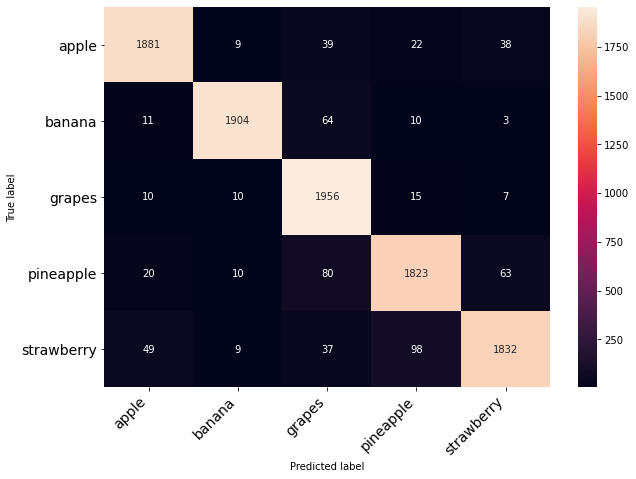

In [23]:
fruit_classes = ['apple', 'banana', 'grapes', 'pineapple', 'strawberry']
confusion_matrix(c_matrix, fruit_classes, figsize = (10,7), fontsize = 14)

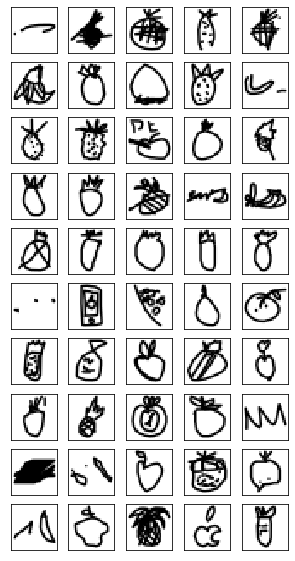

In [24]:
# Misclassification when y_pred and y_test are different.
misclassified = X_test[y_pred_cnn != y_test]
plot_samples(misclassified, rows=10, cols=5, title='')

## Saving Model for Web-App

In [25]:
import pickle
with open('/content/drive/MyDrive/nn_prj/fruit_model_93.96.pkl', 'wb') as file:
      pickle.dump(fruit_model, file)

End of Code